# [DIS 1] ReLUs and Neural Network Intuition

**If you are running on a local anaconda install, you will need to install pytorch with the command**
```sh
conda install pytorch -c pytorch
```

<!-- #TODO(krishna) : add wandb integration -->
<!-- You should immediately run all the cells up through 'Train all layers' since training the networks takes a long time. While you wait you can return to the theory portion of this discussion and work on the backpropagation problem. -->

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import copy
import time
from ipywidgets import fixed, interactive, widgets 

from helpers import *

%matplotlib inline

# Generate Training and Test Data

We are using piecewise linear function. Our training data has added noise $y = f(x) + \epsilon,\, \epsilon \sim \mathcal{N}(0, \sigma^2)$. The test data is noise free.

_Once you have gone through the discussion once you may wish to adjust the number of training samples and noise variance to see how gradient descent behaves under the new conditions._

In [2]:
f_type = 'piecewise_linear'

def f_true(X, f_type):
    if f_type == 'sin(20x)':
        return np.sin(20 * X[:,0])
    else:
        TenX = 10 * X[:,0]
        _ = 12345
        return (TenX - np.floor(TenX)) * np.sin(_ * np.ceil(TenX)) - (TenX - np.ceil(TenX)) * np.sin(_ * np.floor(TenX)) 
    
n_features = 1
n_samples = 200
sigma = 0.1
rng = np.random.RandomState(1)

# Generate train data
X = np.sort(rng.rand(n_samples, n_features), axis=0)
y = f_true(X, f_type) + rng.randn(n_samples) * sigma

# Generate NOISELESS test data
X_test = np.concatenate([X.copy(), np.expand_dims(np.linspace(0., 1., 1000), axis=1)])
X_test = np.sort(X_test, axis=0)
y_test = f_true(X_test, f_type)

# Define the Neural Networks

We will learn the piecewise linear target function using a simple 1-hidden layer neural network with ReLU non-linearity, defined by
$$ \hat{y} = \mathbf{W}^{(2)} \Phi \left( \mathbf{W}^{(1)} x + \mathbf{b}^{(1)} \right) + \mathbf{b}^{(2)} $$
where $\Phi(x) = ReLU(x)$ and superscripts refer to indices, not the power operator.

We will also create two SGD optimizers to allow us to choose whether to train all parameters or only the linear output layer's parameters. Note that we use separate learning rates for the two version of training. There is too much variance in the gradients when training all layers to use a large learning rate, so we have to decrease it.

We will modify the default initialization of the biases so that the ReLU elbows are all inside the region we are interested in.

We create several versions of this network with varying widths to explore how hidden layer width impacts learning performance.

_Once you have gone through the discussion once you may wish to train networks with even larger widths to see how they behave under the three different training paradigms in this notebook._

In [3]:
# Don't rerun this cell after training or you will lose all your work
nets_by_size = {}

In [4]:
widths = [10, 20, 40]
for width in widths:
    # Define a 1-hidden layer ReLU nonlinearity network
    net = nn.Sequential(nn.Linear(1, width),
                        nn.ReLU(),
                        nn.Linear(width, 1))
    loss = nn.MSELoss()
    # Get trainable parameters
    weights_all = list(net.parameters())
    # Get the output weights alone
    weights_out = weights_all[2:]
    # Adjust initial biases so elbows are in [0,1]
    elbows = np.sort(np.random.rand(width))
#     print("Elbows located at:")
#     print(elbows)
    new_biases = -elbows * to_numpy(weights_all[0]).ravel()
    weights_all[1].data = to_torch(new_biases)
    # Create SGD optimizers for outputs alone and for all weights
    lr_out = 0.2
    lr_all = 0.02
    opt_all = torch.optim.SGD(params=weights_all, lr=lr_all)
    opt_out = torch.optim.SGD(params=weights_out, lr=lr_out)
    # Save initial state for comparisons
    initial_weights = copy.deepcopy(net.state_dict())
    # print("Initial Weights", initial_weights)
    nets_by_size[width] = {'net': net, 'opt_all': opt_all, 
                           'opt_out': opt_out, 'init': initial_weights}

## Visualize the starting ReLU corners & slopes, and total function

The dashed lines represent the output of an individual ReLU function in the hidden layer for an $x$ input passed through the first linear layer. The gray points mark the elbows of the ReLU functions where their output becomes non-zero.

Width 10


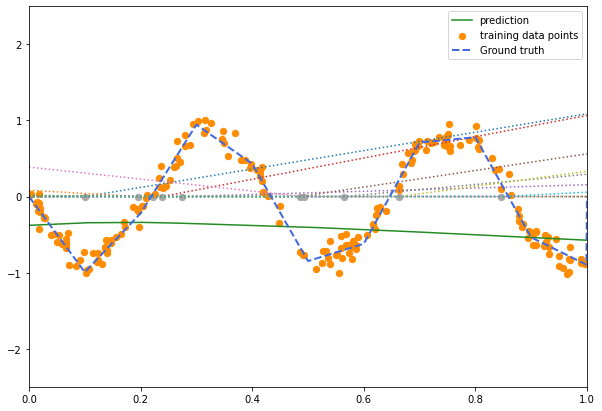

Width 20


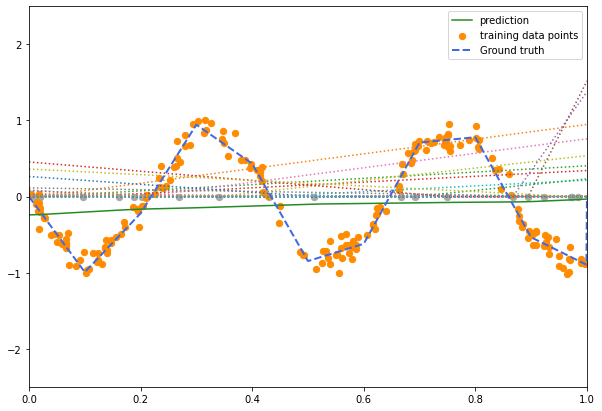

Width 40


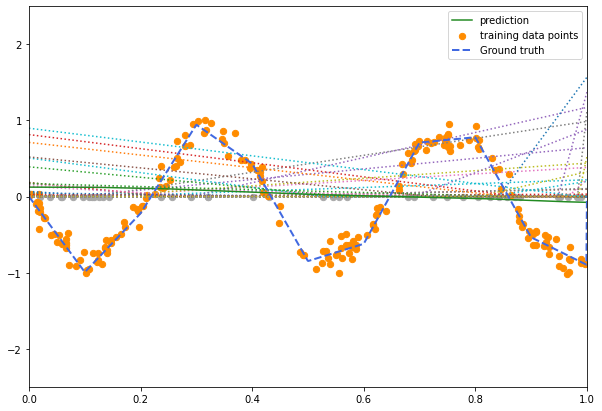

In [5]:
for w in widths:
    net = nets_by_size[w]['net']
    print("Width", w)
    plot_update(X, y, X_test, y_test, net)

# Train all the networks now - this will take a while!
You can expect training to take between 5 and 10 minutes depending on whether you run locally or on datahub and how heavily loaded datahub is at the moment.

## Train only the output layer

----------------------------------------
Width 10
SGD Iteration 10000
SGD Iteration 20000
SGD Iteration 30000
SGD Iteration 40000
SGD Iteration 50000
SGD Iteration 60000
SGD Iteration 70000
SGD Iteration 80000
SGD Iteration 90000
SGD Iteration 100000
SGD Iteration 110000
SGD Iteration 120000
SGD Iteration 130000
SGD Iteration 140000
SGD Iteration 150000
Width 10


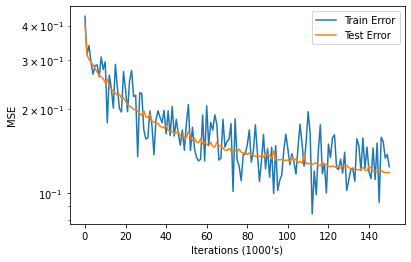

Elapsed time 0.7 minutes
----------------------------------------
Width 20
SGD Iteration 10000
SGD Iteration 20000
SGD Iteration 30000
SGD Iteration 40000
SGD Iteration 50000
SGD Iteration 60000
SGD Iteration 70000
SGD Iteration 80000
SGD Iteration 90000
SGD Iteration 100000
SGD Iteration 110000
SGD Iteration 120000
SGD Iteration 130000
SGD Iteration 140000
SGD Iteration 150000
Width 20


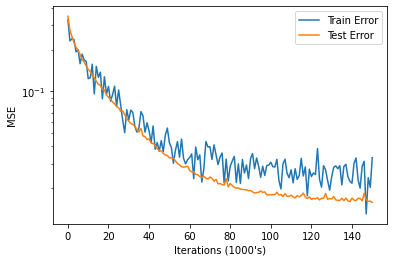

Elapsed time 1.4 minutes
----------------------------------------
Width 40
SGD Iteration 10000
SGD Iteration 20000
SGD Iteration 30000
SGD Iteration 40000
SGD Iteration 50000
SGD Iteration 60000
SGD Iteration 70000
SGD Iteration 80000
SGD Iteration 90000
SGD Iteration 100000
SGD Iteration 110000
SGD Iteration 120000
SGD Iteration 130000
SGD Iteration 140000
SGD Iteration 150000
Width 40


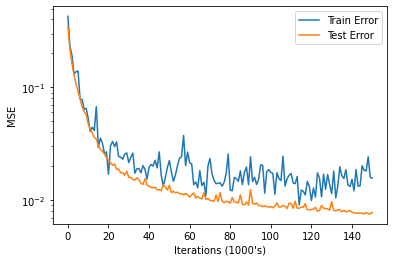

Elapsed time 2.0 minutes
----------------------------------------
Trained output layer in 2.0 minutes


In [6]:
n_steps = 150000
save_every = 1000
t0 = time.time()
for w in widths:
    print("-"*40)
    print("Width", w)
    net = nets_by_size[w]['net']
    opt_out = nets_by_size[w]['opt_out']
    initial_weights = nets_by_size[w]['init']
    history_output = train_network(X, y, X_test, y_test, 
                            net, optim=opt_out, 
                            n_steps=n_steps, save_every=save_every, 
                            initial_weights=initial_weights,
                            verbose=False)
    nets_by_size[w]['hist_out'] = history_output
    print("Width", w)
    plot_test_train_errors(history_output)
    print("Elapsed time %.1f minutes" % ((time.time() - t0) / 60))
t1 = time.time()
print("-"*40)
print("Trained output layer in %.1f minutes" % ((t1 - t0) / 60))

## Train all layers

----------------------------------------
Width 10
SGD Iteration 10000
SGD Iteration 20000
SGD Iteration 30000
SGD Iteration 40000
SGD Iteration 50000
SGD Iteration 60000
SGD Iteration 70000
SGD Iteration 80000
SGD Iteration 90000
SGD Iteration 100000
SGD Iteration 110000
SGD Iteration 120000
SGD Iteration 130000
SGD Iteration 140000
SGD Iteration 150000
Width 10


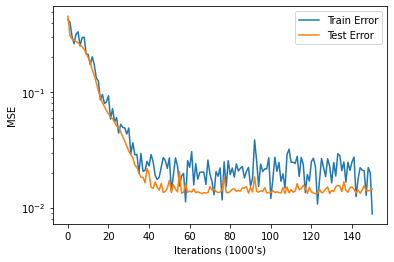

----------------------------------------
Width 20
SGD Iteration 10000
SGD Iteration 20000
SGD Iteration 30000
SGD Iteration 40000
SGD Iteration 50000
SGD Iteration 60000
SGD Iteration 70000
SGD Iteration 80000
SGD Iteration 90000
SGD Iteration 100000
SGD Iteration 110000
SGD Iteration 120000
SGD Iteration 130000
SGD Iteration 140000
SGD Iteration 150000
Width 20


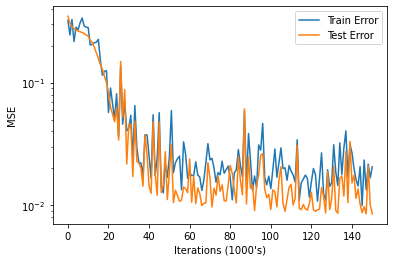

----------------------------------------
Width 40
SGD Iteration 10000
SGD Iteration 20000
SGD Iteration 30000
SGD Iteration 40000
SGD Iteration 50000
SGD Iteration 60000
SGD Iteration 70000
SGD Iteration 80000
SGD Iteration 90000
SGD Iteration 100000
SGD Iteration 110000
SGD Iteration 120000
SGD Iteration 130000
SGD Iteration 140000
SGD Iteration 150000
Width 40


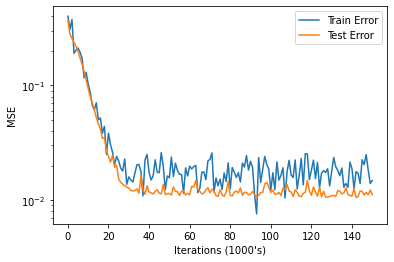

----------------------------------------
Trained all layers in 1.9 minutes


In [7]:
n_steps = 150000
save_every = 1000
t0 = time.time()
for w in widths:
    print("-"*40)
    print("Width", w)
    net = nets_by_size[w]['net']
    opt_all = nets_by_size[w]['opt_all']
    initial_weights = nets_by_size[w]['init']
    history_all = train_network(X, y, X_test, y_test, 
                            net, optim=opt_all, 
                            n_steps=n_steps, save_every=save_every, 
                            initial_weights=initial_weights,
                            verbose=False)
    nets_by_size[w]['hist_all'] = history_all
    print("Width", w)
    plot_test_train_errors(history_all)
t1 = time.time()
print("-"*40)
print("Trained all layers in %.1f minutes" % ((t1 - t0) / 60))

### Train and Test Error
In the train and test error plots, you should observe that, after sufficient training, the test error is consistently lower than the train error. Normally we expect the opposite to happen. **What is causing test error to be lower than train error?**

_Your answer..._

# Learn the Output Layer Using Ridge Regression

We can treat the output of the hidden layer as a featurization of $x$ and use ridge regression to choose weights for the output layer instead of iterating with SGD. We have set up the infrastructure to extract the featurization of the training data and write your learned coefficients back into the network. You will **perform ridge regression with the hidden layer featurization with your choice of regularization parameter $\lambda$** and compare the result with networks learned by gradient descent.

**Learn the last layer weights with ridge regression for each network width and compare the shape of the learned functions, test error, and best regularization coefficients.**

You don't need to rigorously choose the regularization coefficient through cross-validation, but you should at least explore a range of values and pick a reasonable value.

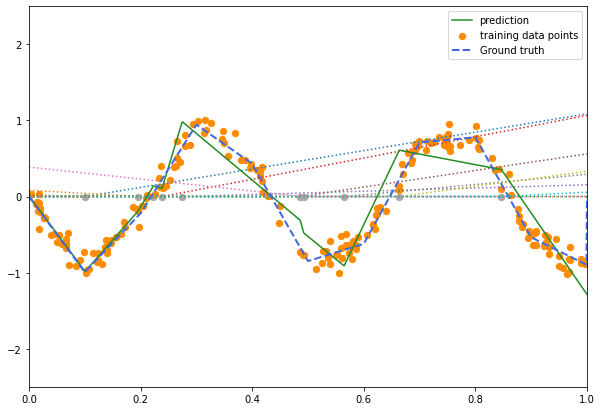

Test Error: 0.03607374539842644


In [8]:
width = 10 # Options are 10, 20, 40
# Reinititalize net
net = nets_by_size[width]['net']
initial_weights = nets_by_size[width]['init']
net.load_state_dict(initial_weights)

# Featurize x using the hidden layer
W1 = initial_weights['0.weight']
b1 = initial_weights['0.bias']
Xnew = to_torch(X) @ W1.T + b1[None, :]
Xnew = to_numpy(nn.functional.relu(Xnew))
# Add the bias term
tmp = np.ones((Xnew.shape[0], width + 1))
tmp[:, :-1] = Xnew
Xnew = tmp

# TODO: Perform ridge regression on the featurization of x
# Store the learned coefficients in a width+1 size array called 'coeffs'
### start last_layer_rr ###
lambd = 1e-5
# w = (X^T X + lambda I)^-1 X^T y
coeffs = np.linalg.solve(Xnew.T @ Xnew + lambd * np.eye(width + 1), Xnew.T @ y)
# print("Learned coeffs:", coeffs)
### end last_layer_rr ###

# Set the output layer parameters to the learned coefficients
bias = to_torch(np.array(coeffs[-1]))
w = to_torch(coeffs[:-1].reshape(1, width))
all_params = list(net.parameters())
all_params[-1].data = bias
all_params[-2].data = w

# Test with learned output layer
plot_update(X, y, X_test, y_test, net)
test_mse = np.mean((to_numpy(net(to_torch(X_test))).ravel() - y_test) ** 2)
print("Test Error:", test_mse)

_Your description of learned function shape and test error dependence on width..._

# Visualize training steps

We saved the network state at regular intervals during the training process. We will visualize the evolution of the network through training below. Pay close attention to the movement of the ReLU elbows and slopes and how they influence the overall learned function. Is there a particular feature of the learned function that is directly influenced by the location of the elbows?

## Train Output Layer Weights Only

Questions to consider while exploring the training process for last layer weights only:
- **How does the hidden layer width impact the learned function and test error?**
- **If you could hand-pick the elbow locations, where would you place them?**
- **How do the final test error and learned function compare to the ridge regression version of training? Which one is more efficient?**

In [9]:
width = 10 # Options are 10, 20, 40
history_output = nets_by_size[width]['hist_out']
net = nets_by_size[width]['net']
make_history_interactive(history_output, X, y, X_test, y_test, net)

interactive(children=(SelectionSlider(description='SGD Iterations: ', options=(1, 1000, 2000, 3000, 4000, 5000…

## Train All Layer Weights

Questions to consider while exploring the training process for all layer weights:
- **How does the hidden layer width impact the learned function and test error?**
- **What happens to the elbow locations during training?**
- **How do the final test error and learned function compare to the ridge regression version of training? Which one is more efficient? Your answer may differ for different hidden layer widths.**

In [10]:
width = 40 # Options are 10, 20, 40
history_all = nets_by_size[width]['hist_all']
net = nets_by_size[width]['net']
make_history_interactive(history_all, X, y, X_test, y_test, net)

interactive(children=(SelectionSlider(description='SGD Iterations: ', options=(1, 1000, 2000, 3000, 4000, 5000…